In [1]:
%load_ext autoreload
%autoreload 2
import gust  # library for loading graph data

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

torch.set_default_tensor_type('torch.cuda.FloatTensor')
%matplotlib inline
sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'numba'

In [ ]:
# Load the dataset using `gust` library
# graph.standardize() makes the graph unweighted, undirected and selects
# the largest connected component
# graph.unpack() returns the necessary vectors / matrices

A, X, _, y = gust.load_dataset('cora').standardize().unpack()
# A - adjacency matrix 
# X - attribute matrix - not needed
# y - node labels

if (A != A.T).sum() > 0:
    raise RuntimeError("The graph must be undirected!")

if (A.data != 1).sum() > 0:
    raise RuntimeError("The graph must be unweighted!")

In [ ]:
num_nodes = A.shape[0]
num_edges = A.sum()

# Convert adjacency matrix to a CUDA Tensor
adj = torch.FloatTensor(A.toarray()).cuda()

In [4]:
torch.manual_seed(123)
# Define the embedding matrix
embedding_dim = 64
emb = nn.Parameter(torch.empty(num_nodes, embedding_dim).normal_(0.0, 1.0))

# Initialize the bias
# The bias is initialized in such a way that if the dot product between two embedding vectors is 0 
# (i.e. z_i^T z_j = 0), then their connection probability is sigmoid(b) equals to the 
# background edge probability in the graph. This significantly speeds up training
edge_proba = num_edges / (num_nodes**2 - num_nodes)
bias_init = np.log(edge_proba / (1 - edge_proba))
b = nn.Parameter(torch.Tensor([bias_init]))

# Regularize the embeddings but don't regularize the bias
# The value of weight_decay has a significant effect on the performance of the model (don't set too high!)
opt = torch.optim.Adam([
    {'params': [emb], 'weight_decay': 1e-7},
    {'params': [b]}],
    lr=1e-2)

In [5]:
# There are many ways to compute the loss / negative log-likelihood of the model
def compute_loss_v1(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    loss = F.binary_cross_entropy_with_logits(logits, adj, reduction='none')
    # Since we consider graphs without self-loops, we don't want to compute loss
    # for the diagonal entries of the adjacency matrix.
    # This will kill the gradients on the diagonal.
    loss[np.diag_indices(adj.shape[0])] = 0.0
    return loss.mean()

# This function uses the torch.distributions module
def compute_loss_v2(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    distribution = dist.Bernoulli(logits=logits)
    log_probas = distribution.log_prob(adj)
    log_probas[np.diag_indices(adj.shape[0])] = 0.0
    loss = -log_probas.mean()
    return loss

# Here we compute the loss manually
def compute_loss_v3(adj, emb, b=0.0): 
    """Compute the negative log-likelihood of the Bernoulli model."""
    logits = emb @ emb.t() + b
    log_probas = adj * logits - F.softplus(logits)
    log_probas[np.diag_indices(adj.shape[0])] = 0.0
    loss = -log_probas.mean()
    return loss

compute_loss = compute_loss_v1

# In general, it's very important to compute all the losses in a numerically stable way
# (e.g. using the log-sum-exp trick) or use existing library functions

In [6]:
max_epochs = 5000
display_step = 250

for epoch in range(max_epochs):
    opt.zero_grad()
    loss = compute_loss(adj, emb, b)
    loss.backward()
    opt.step()
    # Training loss is printed every display_step epochs
    if epoch % display_step == 0:
        print(f'Epoch {epoch:4d}, loss = {loss.item():.5f}')

Epoch    0, loss = 1.01289
Epoch  250, loss = 0.01120
Epoch  500, loss = 0.00457
Epoch  750, loss = 0.00280
Epoch 1000, loss = 0.00208
Epoch 1250, loss = 0.00169
Epoch 1500, loss = 0.00145
Epoch 1750, loss = 0.00128
Epoch 2000, loss = 0.00116
Epoch 2250, loss = 0.00106
Epoch 2500, loss = 0.00098
Epoch 2750, loss = 0.00092
Epoch 3000, loss = 0.00086
Epoch 3250, loss = 0.00081
Epoch 3500, loss = 0.00077
Epoch 3750, loss = 0.00073
Epoch 4000, loss = 0.00070
Epoch 4250, loss = 0.00066
Epoch 4500, loss = 0.00063
Epoch 4750, loss = 0.00061


In [7]:
# We need to transform 64-dimensional embedding into 2d for visualization
# For this we can either use t-SNE from scikit-learn or UMAP
# umap package can be installed with `pip install umap`

# from sklearn.manifold import TSNE
from umap import UMAP as TSNE

def visualize(emb, y):
    emb = emb.cpu().detach().numpy()
    tsne = TSNE()
    vis = tsne.fit_transform(emb)
    plt.figure(figsize=[10, 8])
    plt.scatter(vis[:, 0], vis[:, 1], c=palette[y], s=20, alpha=0.8)
    
# Alternative to the default seaborn palette
palette = np.array(sns.color_palette('muted', n_colors=len(np.unique(y))))

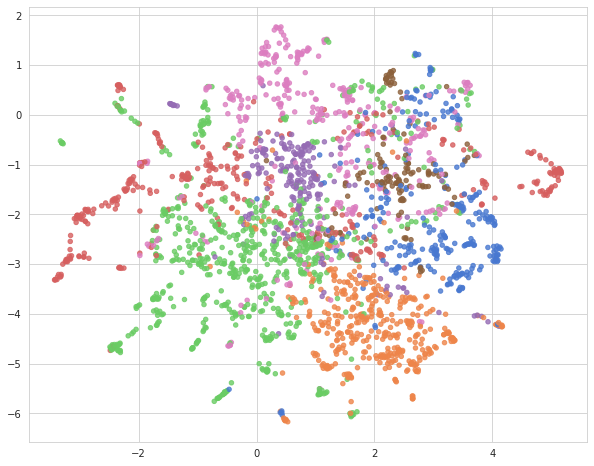

In [9]:
visualize(emb, y)

# Models that need to be implemented
## 1. Bernoulli models
Learn embeddings by maximizing the objective 
$$\max_{Z \in \mathbb{R}^{N \times D}} \log p(A | Z)$$
where
$$p(A | Z) = \prod_{i < j} Bernoulli(A_{ij}| f(z_i, z_j))$$

- Sigmoid model
$$f(z_i, z_j) = \sigma(z_i^T z_j + b)$$

$\;$
- Distance-based model #1
$$f(z_i, z_j) = \exp(-\gamma||z_i^T - z_j||)$$

$\;$
- Distance-based model #2 (https://arxiv.org/pdf/1905.13177.pdf, Equation 6)
$$f(z_i, z_j) = \sigma(C(1 - ||z_i^T - z_j||))$$
they use $C = 10$ in the paper.

## 2. Categorical cross-entropy models
Learn embeddings by optimizing the objective 
$$\min_{Z \in \mathbb{R}^{N \times D}} \mathbb{KL}(M || \operatorname{softmax}(Z Z^T))$$
note that we don't need to add a bias term here since $\operatorname{softmax}(x) = \operatorname{softmax}(x + c)$ for any vector $x$ and constant $c$.

Choices for $M$:
- Transition matrix $M = P = D^{-1}A$, where $D_{ii} = \sum_{ij} A_{ij}$, $D_{ij} = 0$ if $i \ne j$.
- Personalized PageRank matrix $M = (I - \alpha P)^{-1}$(https://arxiv.org/pdf/1803.04742.pdf)
- Finite-step transition matrix (i.e. average of powers of the transition matrix) $\frac{1}{T} \sum_{t=1}^{T} P^{t}$ (https://arxiv.org/pdf/1702.05764.pdf). This is equivalent to the popular DeepWalk method (https://arxiv.org/abs/1403.6652)

## Different model variants for (1) and (2)

You should consider two options for modeling the embeddings:
 - Learning $Z \in \mathbb{R}^{N \times D}$, get a "score" as $z_i^T z_j$
 - Learning $Z \in \mathbb{R}^{N \times D}$ and $W \in \mathbb{R}^{D \times D}$, get a "score" as $z_i^T W z_j$
 
The first option might not be capable to model networks with heterophily, but the second option requires learning more parameters. You should implement both version and see which works better.

## 3. Methods based on SVD / Matrix factorization
You obtain embeddings in these methods by performing SVD / eigendecomposition (no need to perform gradient descent here).

- NetMF - see Algorithm 3 & 4 in (https://arxiv.org/pdf/1710.02971.pdf)
- Spectral clustering - see MMDS lecture